In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/open/train.csv', index_col = 'ID')
test = pd.read_csv('/content/drive/MyDrive/open/test.csv', index_col = 'ID')

In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/open/sample_submission.csv')

In [ ]:
train

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
ID,,,,,,,,,,,,,,
TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRAIN_96289,14400000,36 months,10+ years,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C
TRAIN_96290,28800000,60 months,10+ years,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E
TRAIN_96291,14400000,36 months,1 year,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96294 entries, TRAIN_00000 to TRAIN_96293
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   대출금액          96294 non-null  int64  
 1   대출기간          96294 non-null  object 
 2   근로기간          96294 non-null  object 
 3   주택소유상태        96294 non-null  object 
 4   연간소득          96294 non-null  int64  
 5   부채_대비_소득_비율   96294 non-null  float64
 6   총계좌수          96294 non-null  int64  
 7   대출목적          96294 non-null  object 
 8   최근_2년간_연체_횟수  96294 non-null  int64  
 9   총상환원금         96294 non-null  int64  
 10  총상환이자         96294 non-null  float64
 11  총연체금액         96294 non-null  float64
 12  연체계좌수         96294 non-null  float64
 13  대출등급          96294 non-null  object 
dtypes: float64(4), int64(5), object(5)
memory usage: 11.0+ MB


In [ ]:
# 먼저 결측치 존재 확인
train.isna().sum()
# 확인 결과 결측치는 없음

대출금액            0
대출기간            0
근로기간            0
주택소유상태          0
연간소득            0
부채_대비_소득_비율     0
총계좌수            0
대출목적            0
최근_2년간_연체_횟수    0
총상환원금           0
총상환이자           0
총연체금액           0
연체계좌수           0
대출등급            0
dtype: int64

In [ ]:
nuniq = train.nunique()
nuniq

대출금액             1340
대출기간                2
근로기간               16
주택소유상태              4
연간소득             7726
부채_대비_소득_비율      4025
총계좌수              109
대출목적               12
최근_2년간_연체_횟수       20
총상환원금           27797
총상환이자           35626
총연체금액             109
연체계좌수               4
대출등급                7
dtype: int64

In [ ]:
# 이상치 제거
columns = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '총상환원금', '총상환이자', '총연체금액']
for column in columns:
    Q1 = train[column].quantile(0.25)
    Q3 = train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 이상치가 아닌 데이터만 필터링
    train = train[(train[column] >= lower_bound) & (train[column] <= upper_bound)]

In [ ]:
'''
nuniq를 보고 전처리 해줘야 할 변수 결정
대출기간은 바이너리로 해줘도 될듯(36month를 1로)
주택소유상태는 원핫인코딩
대출목적은 일단 원핫인코딩 실시, 차원이 너무 커지면 차원축소 시도하거나 없애거나..
근로기간은 확인해본 결과 동일한 내용이 다른 문구로 입력되어 있는 경우가 있어 전처리 필요할듯
'''

col_nuniq = nuniq[nuniq <= 20].index
for i in col_nuniq:
  print(f'{i}의 도메인 : ', train[i].unique().tolist())

대출기간의 도메인 :  [' 36 months', ' 60 months']
근로기간의 도메인 :  ['6 years', '10+ years', '5 years', '8 years', 'Unknown', '9 years', '2 years', '3 years', '7 years', '4 years', '< 1 year', '1 year', '10+years', '<1 year', '3', '1 years']
주택소유상태의 도메인 :  ['RENT', 'MORTGAGE', 'OWN', 'ANY']
대출목적의 도메인 :  ['부채 통합', '주택 개선', '주요 구매', '휴가', '의료', '자동차', '신용 카드', '소규모 사업', '기타', '이사', '주택', '재생 에너지']
최근_2년간_연체_횟수의 도메인 :  [0, 1, 11, 2, 3, 4, 6, 5, 14, 8, 7, 10, 13, 9, 12, 16, 18]
연체계좌수의 도메인 :  [0.0, 1.0, 2.0, 4.0]
대출등급의 도메인 :  ['C', 'B', 'A', 'D', 'F', 'E', 'G']


In [ ]:
# 먼저 근로기간부터 전처리
train['근로기간'] = train['근로기간'].str.replace('years','year')
train['근로기간'] = train['근로기간'].str.replace('year','')
train['근로기간'] = train['근로기간'].str.replace('+','')
train['근로기간'] = train['근로기간'].str.replace('< 1','<1')
train['근로기간'] = train['근로기간'].str.strip()

test['근로기간'] = test['근로기간'].str.replace('years','year')
test['근로기간'] = test['근로기간'].str.replace('year','')
test['근로기간'] = test['근로기간'].str.replace('+','')
test['근로기간'] = test['근로기간'].str.replace('< 1','<1')
test['근로기간'] = test['근로기간'].str.strip()

train['근로기간'].unique()

<ipython-input-125-a24556a136ef>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train['근로기간'] = train['근로기간'].str.replace('+','')
<ipython-input-125-a24556a136ef>:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test['근로기간'] = test['근로기간'].str.replace('+','')


array(['6', '10', '5', '8', 'Unknown', '9', '2', '3', '7', '4', '<1', '1'],
      dtype=object)

<Axes: >

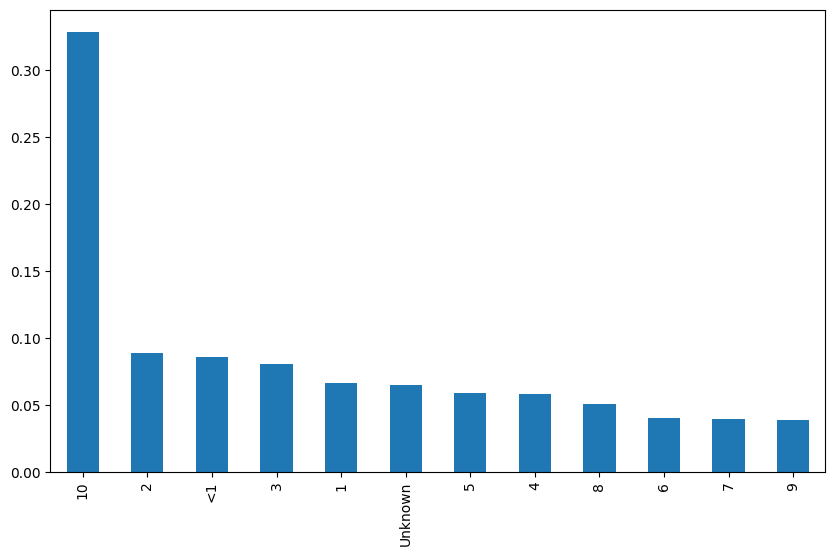

In [ ]:
data_work_ = train['근로기간'].value_counts(1)
data_work = pd.DataFrame(data_work_)
data_work['근로기간'].plot(kind='bar', figsize=(10, 6))
# value_count 결과 Unknown의 비율은 약 5.88%, 일단 Unknown의 값을 결측치로 하고 제거하자 그리고  <1를 0으로 변환하고 숫자형 변수로 변환하는게 타당할듯

In [ ]:
train['근로기간'] = train['근로기간'].str.replace('<1','0')
test['근로기간'] = test['근로기간'].str.replace('<1','0')

In [ ]:
train_eda1 = train.dropna()
test_eda1 = test

In [ ]:
train_eda1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80206 entries, TRAIN_00000 to TRAIN_96293
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   대출금액          80206 non-null  int64  
 1   대출기간          80206 non-null  object 
 2   근로기간          80206 non-null  object 
 3   주택소유상태        80206 non-null  object 
 4   연간소득          80206 non-null  int64  
 5   부채_대비_소득_비율   80206 non-null  float64
 6   총계좌수          80206 non-null  int64  
 7   대출목적          80206 non-null  object 
 8   최근_2년간_연체_횟수  80206 non-null  int64  
 9   총상환원금         80206 non-null  int64  
 10  총상환이자         80206 non-null  float64
 11  총연체금액         80206 non-null  float64
 12  연체계좌수         80206 non-null  float64
 13  대출등급          80206 non-null  object 
dtypes: float64(4), int64(5), object(5)
memory usage: 9.2+ MB


In [ ]:
'''
대출목적의 도메인 :  ['부채 통합', '주택 개선', '주요 구매', '휴가', '의료', '자동차', '신용 카드', '소규모 사업', '기타', '이사', '주택', '재생 에너지']
이니까 일단 이걸 오류없이 하려면 영어로 재정의 필요
사실 컬럼명도 다 영어로 바꾸는게 좋은데..하자
'''

col_name_kor = train_eda1.columns.tolist()
col_name_eng = ['loan_money', 'loan_period', 'work_period', 'own_house', 'income_year', 'ratio_income_per_loan', 'account', 'purpose', 'overdue_times', 'total_redeemed_principal', 'total_redeemed_int', 'overdue-tot', 'overdue_account', 'rank']
train_eda1.set_axis(col_name_eng, axis=1, inplace=True)

<ipython-input-132-bc2ecd58a4c6>:9: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  train_eda1.set_axis(col_name_eng, axis=1, inplace=True)


In [ ]:
col_name_eng.remove('rank')
test_eda1.set_axis(col_name_eng, axis = 1, inplace = True)

<ipython-input-133-5cb39ae2a414>:2: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  test_eda1.set_axis(col_name_eng, axis = 1, inplace = True)


In [ ]:
train_eda1['purpose'].unique()

array(['부채 통합', '주택 개선', '주요 구매', '휴가', '의료', '자동차', '신용 카드', '소규모 사업',
       '기타', '이사', '주택', '재생 에너지'], dtype=object)

In [ ]:
train_eda1['purpose'] = train_eda1['purpose'].replace({'부채 통합': 'loan_integration', '주택 개선': 'house_improvement', '휴가': 'vacation', '의료': 'medical', '자동차': 'car',
                                                       '기타': 'ext', '신용 카드': 'credit_card', '주요 구매': 'buy', '이사': 'house_move', '소규모 사업': 'small_business', '주택': 'house', '재생 에너지': 'renewable_energy'})
test_eda1['purpose'] = test_eda1['purpose'].replace({'부채 통합': 'loan_integration', '주택 개선': 'house_improvement', '휴가': 'vacation', '의료': 'medical', '자동차': 'car',
                                                       '기타': 'ext', '신용 카드': 'credit_card', '주요 구매': 'buy', '이사': 'house_move', '소규모 사업': 'small_business', '주택': 'house', '재생 에너지': 'renewable_energy'})

In [ ]:
train_eda1['loan_period'] = (train_eda1['loan_period'] == ' 60 months').astype(int)
test_eda1['loan_period'] = (test_eda1['loan_period'] == ' 60 months').astype(int)

In [ ]:
# 다시 체크
nuniq = train_eda1.nunique()
col_nuniq = nuniq[nuniq <= 20].index
for i in col_nuniq:
  print(f'{i}의 도메인 : ', train_eda1[i].unique().tolist())

loan_period의 도메인 :  [0, 1]
work_period의 도메인 :  ['6', '10', '5', '8', 'Unknown', '9', '2', '3', '7', '4', '0', '1']
own_house의 도메인 :  ['RENT', 'MORTGAGE', 'OWN', 'ANY']
purpose의 도메인 :  ['loan_integration', 'house_improvement', 'buy', 'vacation', 'medical', 'car', 'credit_card', 'small_business', 'ext', 'house_move', 'house', 'renewable_energy']
overdue_times의 도메인 :  [0, 1, 11, 2, 3, 4, 6, 5, 14, 8, 7, 10, 13, 9, 12, 16, 18]
overdue-tot의 도메인 :  [0.0]
overdue_account의 도메인 :  [0.0, 1.0, 2.0, 4.0]
rank의 도메인 :  ['C', 'B', 'A', 'D', 'F', 'E', 'G']


In [ ]:
train_eda1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80206 entries, TRAIN_00000 to TRAIN_96293
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   loan_money                80206 non-null  int64  
 1   loan_period               80206 non-null  int64  
 2   work_period               80206 non-null  object 
 3   own_house                 80206 non-null  object 
 4   income_year               80206 non-null  int64  
 5   ratio_income_per_loan     80206 non-null  float64
 6   account                   80206 non-null  int64  
 7   purpose                   80206 non-null  object 
 8   overdue_times             80206 non-null  int64  
 9   total_redeemed_principal  80206 non-null  int64  
 10  total_redeemed_int        80206 non-null  float64
 11  overdue-tot               80206 non-null  float64
 12  overdue_account           80206 non-null  float64
 13  rank                      80206 non-null  object 


In [ ]:
train_eda1.nunique()

loan_money                   1279
loan_period                     2
work_period                    12
own_house                       4
income_year                  6466
ratio_income_per_loan        3977
account                        53
purpose                        12
overdue_times                  17
total_redeemed_principal    22492
total_redeemed_int          28598
overdue-tot                     1
overdue_account                 4
rank                            7
dtype: int64

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

feature_num = train_eda1.select_dtypes(include="number").columns
column_transformer = make_column_transformer(
    (StandardScaler(), feature_num),
    (OneHotEncoder(handle_unknown='ignore'), ['own_house', 'purpose', 'work_period'])
)

train_eda1_transformed = column_transformer.fit_transform(train_eda1)
test_eda1_transformed = column_transformer.transform(test_eda1)

In [ ]:
# 핸들링 편하게 반환값들을 데이터프레임으로 변환

ohe_col = column_transformer.named_transformers_['onehotencoder'].get_feature_names_out(['own_house', 'purpose', 'work_period'])
new_column_names = feature_num.tolist() + list(ohe_col)

train_eda1_transformed_df = pd.DataFrame(train_eda1_transformed, columns=new_column_names, index=train_eda1.index)
test_eda1_transformed_df = pd.DataFrame(test_eda1_transformed, columns=new_column_names, index=test_eda1.index)

In [ ]:
# 최종적으로 train, test set 정의

X_train = train_eda1_transformed_df
y_train = train_eda1['rank']

X_test = test_eda1_transformed_df

<Axes: >

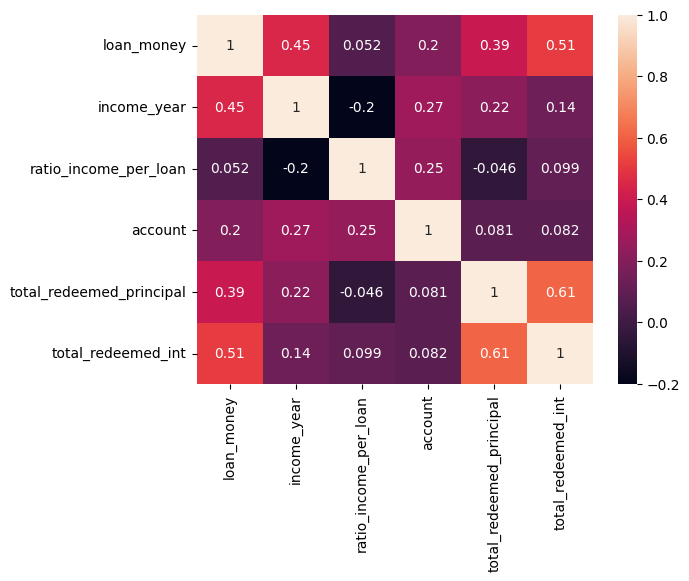

In [ ]:
# X_train에서 상관관계 구현
nuniq = X_train.nunique()
corr_feature = nuniq[nuniq > 18].index.tolist()
corr_matrix = X_train[corr_feature].corr()
sns.heatmap(corr_matrix, annot = True)
# 상관관계 구현 결과 특이 피쳐 없음

cumulative_explained_variance: [0.07596363 0.12802755 0.17391669 0.21096131 0.24532541 0.27893594
 0.31041396 0.341185   0.37084365 0.40030232 0.42949456 0.45834781
 0.48712811 0.51572729 0.54413069 0.57238755 0.60049054 0.62853993
 0.65620777 0.68378852 0.71108281 0.73825397 0.76536106 0.79238144
 0.81935514 0.84623524 0.87295637 0.89959342 0.9254748  0.9498266
 0.97247527 0.98684479 0.99608248 1.         1.         1.
 1.         1.        ]


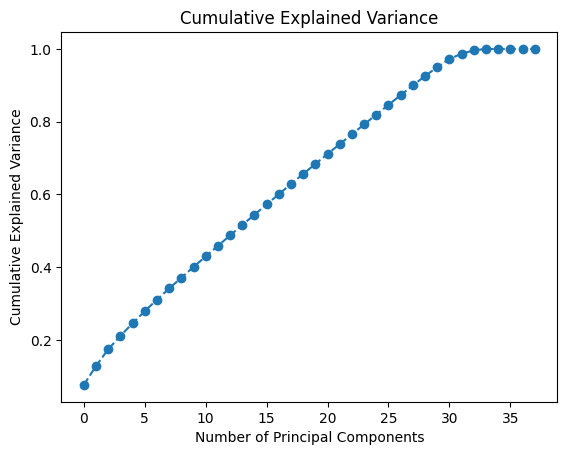

In [ ]:
# PCA 적용

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Scaler = StandardScaler()
X_train_scaled = Scaler.fit_transform(X_train)

PCA = PCA()
PCA.fit(X_train_scaled)

X_pca = PCA.transform(X_train_scaled)

# 결과 요약
explained_variance_ratio = PCA.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
print('cumulative_explained_variance:', cumulative_explained_variance)

# scree plot
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

loadings = pd.DataFrame(PCA.components_.T, columns=[f'PC{i+1}' for i in range(PCA.components_.shape[0])], index=X_train.columns)

# 데이터를 95% 이상 설명하려면 n_components는 21부터 적용해야 함. 이러면 오버피팅 방지가 가능할 것으로 추정
# 21개 사용하는 것은 경제적으로 유의미하지 않음(27개에서 21개로, 더 효과적인 방법을 찾아야 함)

In [ ]:
# n_components = 21으로 적용 시도
from sklearn.decomposition import PCA

pca = PCA(n_components=21)
pca.fit(X_train_scaled)
X_pca_21 = pca.transform(X_train_scaled)
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])], index=X_train.columns)
loadings[loadings > 0.5].count()

# PCA를 통해 각 성분들을 그룹화할 수 있어 시도하였으나 유의미한 값은 없음
# 아마 바이너리 데이터가 많아서 그룹핑이 되지 않는 것 같음, PCA말고 다른 차원축소기법을 이용해야 할듯.
# 이 데이터에서는 차원축소를 통한 오버피팅 방지라는 기술적 측면에서만 PCA 사용 가능(차원수 : 21일때 96%이상 설명 가능)

PC1     0
PC2     0
PC3     1
PC4     1
PC5     0
PC6     1
PC7     2
PC8     1
PC9     1
PC10    0
PC11    1
PC12    1
PC13    1
PC14    0
PC15    0
PC16    0
PC17    1
PC18    2
PC19    0
PC20    0
PC21    0
dtype: int64

In [ ]:
# 베이지안 최적화 시도
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.ensemble import RandomForestClassifier

# 모델 평가 함수 정의
def rf_cv(n_estimators, max_depth, min_samples_leaf, min_samples_split):
    estimator = RandomForestClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_leaf=int(min_samples_leaf),
        min_samples_split=int(min_samples_split),
        random_state=42
    )
    cval = cross_val_score(estimator, X_train, y_train, scoring='accuracy', cv=5)
    return cval.mean()

# 하이퍼파라미터의 범위 정의 (실수 형태로)
param_bounds = {
    'n_estimators': (100, 500),
    'max_depth': (3, 20),
    'min_samples_leaf': (2, 10),
    'min_samples_split': (2, 10)
}

# BayesianOptimization 객체 생성 및 최적화 실행
optimizer = BayesianOptimization(
    f=rf_cv,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(
    init_points=3,
    n_iter=10,
)

# 최적화 결과 출력
print(optimizer.max)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.5507    | 9.367     | 9.606     | 7.856     | 339.5     |
| 2         | 0.4477    | 5.652     | 3.248     | 2.465     | 446.5     |
| 3         | 0.6293    | 13.22     | 7.665     | 2.165     | 488.0     |
| 4         | 0.6447    | 14.01     | 7.614     | 3.409     | 488.9     |
| 5         | 0.705     | 19.94     | 3.823     | 9.857     | 499.1     |
| 6         | 0.6843    | 17.79     | 4.916     | 4.798     | 100.0     |
| 7         | 0.6155    | 12.69     | 6.401     | 5.993     | 130.9     |
| 8         | 0.7103    | 19.77     | 2.571     | 9.168     | 225.0     |
| 9         | 0.3885    | 3.048     | 7.955     | 3.008     | 245.0     |
| 10        | 0.7149    | 20.0      | 2.0       | 10.0      | 207.7     |
| 11        | 0.389     | 3.0       | 10.0      | 10.0      | 188.7     |
| 12        | 0.3879    | 3.0       | 

In [ ]:
model_rf_bo = RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=207)
model_rf_bo.fit(X_train, y_train)
predictions = model_rf_bo.predict(X_test)
sample_submission['대출등급'] = predictions
sample_submission.to_csv('submission_v1.csv', index=False)

In [ ]:
|# UMAP이라는 차원축소 스킬이 있어 한번 써보려고 함

import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

# 데이터 로드
X_train_umap = X_train
X_test_umap = X_test
y_train_umap = y_train

# UMAP 모델 생성
reducer = umap.UMAP(n_components=5)
X_train_reduced = reducer.fit_transform(X_train_umap)
X_test_reduced = reducer.transform(X_test_umap)

ValueError: Input contains NaN.

In [ ]:
# UMAP기법으로 축소된 데이터로 베이지안 최적화 시도
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.ensemble import RandomForestClassifier

# 모델 평가 함수 정의
def rf_cv(n_estimators, max_depth, min_samples_leaf, min_samples_split):
    estimator = RandomForestClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_leaf=int(min_samples_leaf),
        min_samples_split=int(min_samples_split),
        random_state=42
    )
    cval = cross_val_score(estimator, X_train_reduced, y_train_umap, scoring='accuracy', cv=5)
    return cval.mean()

# 하이퍼파라미터의 범위 정의 (실수 형태로)
param_bounds = {
    'n_estimators': (100, 200),
    'max_depth': (3, 20),
    'min_samples_leaf': (2, 10),
    'min_samples_split': (2, 10)
}

# BayesianOptimization 객체 생성 및 최적화 실행
optimizer = BayesianOptimization(
    f=rf_cv,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(
    init_points=3,
    n_iter=15,
)

# 최적화 결과 출력
print(optimizer.max)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.4046    | 9.367     | 9.606     | 7.856     | 159.9     |
| 2         | 0.3844    | 5.652     | 3.248     | 2.465     | 186.6     |
| 3         | 0.4108    | 13.22     | 7.665     | 2.165     | 197.0     |
| 4         | 0.4118    | 15.29     | 7.344     | 3.783     | 106.4     |
| 5         | 0.3717    | 3.837     | 2.148     | 6.804     | 172.4     |
| 6         | 0.372     | 3.076     | 2.323     | 5.732     | 135.2     |
| 7         | 0.4091    | 19.5      | 7.677     | 9.951     | 137.4     |
| 8         | 0.4102    | 11.02     | 3.284     | 8.416     | 109.7     |
| 9         | 0.4095    | 19.49     | 7.946     | 7.845     | 115.0     |
| 10        | 0.4056    | 20.0      | 2.0       | 10.0      | 100.0     |
| 11        | 0.4093    | 20.0      | 10.0      | 3.4       | 151.0     |
| 12        | 0.4104    | 14.52     | 

In [ ]:
model_rf_bo = RandomForestClassifier(max_depth=15, min_samples_leaf=7, min_samples_split=3, n_estimators=106)
model_rf_bo.fit(X_train_reduced, y_train_umap)
predictions = model_rf_bo.predict(X_test_reduced)
sample_submission['대출등급'] = predictions
sample_submission.to_csv('final_submission.csv', index=False)

ValueError: Length of values (60335) does not match length of index (64197)